# SDA Project

Module code: 7CUSMSDA

Student number: 1887975

Made in Python 3.6


Contents:

<a href='#Import packages and configure options'>1. Import packages and configure options</a>

<a href='#Sources'>2. Sources</a>

<a href='#Curation'>3. Curation</a>

<a href='#Map formatting'>4. Map formatting</a>

<a href='#Tourism and accommodation descriptive'>5. Tourism and accommodation descriptive</a>

<a href='#Airbnb and other accommodation capacity Data Zone level comparison'>6. Airbnb and other accommodation capacity Data Zone level comparison</a>

<a href='#Deprivation'>7. Deprivation</a>

## <a id="Import packages and configure options">1. Importing packages and configure options <a/>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import pointpats 
from pointpats import PointPattern
from copy import deepcopy
import sys
import os
import re
from copy import deepcopy
import pysal as ps
import libpysal as lps
from pysal.spreg import ml_error
from shapely.geometry import Point
from pysal import esda
from pysal.contrib.viz import mapping as viz
from pyproj import Proj, transform
from pointpats.centrography import mean_center, weighted_mean_center, \
manhattan_median, euclidean_median
from pointpats.centrography import std_distance,ellipse

sns.set(color_codes=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sys.path.append(os.path.abspath('..'))

## <a id="Sources">2. Sources <a/>

In [2]:
#Import Ordanance Survey points of interest data
poi = pd.read_csv("data/poiOS.csv")
poi_lookup = pd.read_csv("data/poi_dict.csv")

#Import Open Street Map points of interest data
scot_osm = gpd.read_file("data/SCOT_poi/gis_osm_pois_free_1.shp", 
                         crs={'init': 'epsg:4326'})
scot_osm = scot_osm.to_crs(epsg=3857)

#Import Airbnb listings
ed_airbnb = pd.read_csv("data/listings.csv", low_memory=False)
#ed_airbnb = pd.read_csv("data/edinburgh_listings.csv")

#Import Datazone boundaries
datazone = gpd.read_file("data/datazone/SG_DataZone_Bdry_2011.shp", 
                         crs={'init': 'epsg:27700'} )
datazone= datazone.to_crs(epsg=3857)

#Import Scottish Index of deprivation lookups
simd = pd.read_csv("data/simd2016_withinds.csv")

## <a id="Curation">3. Curation <a/>

In [4]:
#Merge shapefile with lookup table that just has Edinburgh data zones
datazone2 = datazone.merge(simd, left_on="DataZone", right_on="Data_Zone", 
                           how="inner")
datazone2 = datazone2.loc[datazone2["Council_area"] == "City_of_Edinburgh"]
datazone2 = datazone2.set_index(["DataZone"])

#Create edinburgh boundary
datazone2["dummy"] = "dummy"
edinburgh = datazone2.dissolve(by="dummy")
edinburgh = edinburgh[["geometry"]]

In [5]:
#Define function to extract characters
def extract_char(text):
    x = re.findall(r"[\d|\w|\s]+", text)
    return x[0]

In [6]:
#Change point of interest lookup column names
poi_lookup.columns = ["ID", "L3_code", "L3_desc", "L2_code"]

#Add level 2 high level category names to poi lookup frame
conditions = [
    (poi_lookup["L2_code"] == '"16"'),
    (poi_lookup["L2_code"] == '"17"'),
    (poi_lookup["L2_code"] == '"18"'),
    (poi_lookup["L2_code"] == '"19"'),
    (poi_lookup["L2_code"] == '"20"'),
    (poi_lookup["L2_code"] == '"58"'),
    (poi_lookup["L2_code"] == '"24"'),
    (poi_lookup["L2_code"] == '"25"'),
    (poi_lookup["L2_code"] == '"33"'),
    (poi_lookup["L2_code"] == '"34"')]

choices = ["BOTANICAL AND ZOOLOGICAL", "HISTORICAL AND CULTURAL", 
           "RECREATIONAL", "LANDSCAPE FEATURES", "TOURISM",
         "BODIES OF WATER", "SPORTS COMPLEX", "VENUES, STAGE AND SCREEN", 
           "CENTRAL AND LOCAL GOVERNMENT", "INFRASTRUCTURE AND FACILITIES"]

#Create new column with description of level 2 code
poi_lookup["L2_desc"] = np.select(conditions, choices, default=np.nan)
poi_lookup = poi_lookup.replace("nan", np.nan)

#extract digits from Class Number
poi_lookup["L3_code"] = poi_lookup["L3_code"].apply(extract_char)
poi_lookup["L3_desc"] = poi_lookup["L3_desc"].apply(extract_char)
poi_lookup["L2_code"] = poi_lookup["L2_code"].apply(extract_char)

In [7]:
#Create new column with class number that is last 4 digits of PointX Class
poi["L3_code"] = poi["PointX Classification Code"].apply(lambda x: str(x)[-4:])

#Merge poi data with lookup table
poi2 = poi.merge(poi_lookup, how="left")

#Extract coordinates and convert to point type
poi2["coordinates"] = list(zip(poi2["Feature Easting"], 
                               poi2["Feature Northing"]))
poi2["coordinates"] = poi2["coordinates"].apply(Point)

#Create Geodataframe
poi3 = gpd.GeoDataFrame(poi2, geometry= "coordinates", 
                        crs={'init': 'epsg:27700'})
poi3 = poi3.to_crs(epsg=3857)

#Remove irelevant pois
poi4 = poi3.dropna(subset=["L2_desc"])

poi4 = poi4.rename(columns={"Name": "poi_name" })

#Create dataframe with just edinburgh poi
ed_poi = gpd.sjoin(poi4, edinburgh, how="inner", op='within')

In [60]:
#Top 10 attractions in Edinburgh
POI_10 = ["Scottish National Gallery",  
          'Edinburgh Castle', 'National Museum Scotland', "St Giles Cathedral", 
          "The Scotch Whisky Experience", 
          "National War Museum"]
          

ed_poi_main = ed_poi.loc[ed_poi.poi_name.isin(POI_10)]
d = {'National Museum Scotland': "1",
     'Edinburgh Castle': "2", "National War Museum":"6", 
     "The Scotch Whisky Experience":
     "10", "Scottish National Gallery":"3", "St Giles Cathedral":"4"}
ed_poi_main["number"] = ed_poi_main.poi_name.map(d)

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [9]:
#Attraction areas in Edinburgh
POI_short = ["The Royal Yacht Britannia", 
          'Edinburgh Castle', "Royal Botanic Garden Edinburgh", 
             "Scottish National Gallery of Modern Art", 'Edinburgh Zoo', 
             'Queensferry Museum',
         "Portobello Swimming Pool (Swimming Pool)", "Craigmillar Castle", 
             "Fort (Holyrood Park)"]

ed_poi_main2 = ed_poi.loc[ed_poi.poi_name.isin(POI_short)]
ed_poi_main2 = ed_poi_main2.drop([13874, 12067])
d2 = {"Edinburgh Zoo": "E", "Royal Botanic Garden Edinburgh": "G",
     'Edinburgh Castle': "D","The Royal Yacht Britannia": "H", 
      "Scottish National Gallery of Modern Art":"F",
     'Queensferry Museum':"I", "Portobello Swimming Pool (Swimming Pool)":"B",
      "Craigmillar Castle":"A", "Fort (Holyrood Park)":"C" }
ed_poi_main2["number"] = ed_poi_main2.poi_name.map(d2)

In [10]:
#List of accommodations in OpenStreetMap
accom_list = ["bed_and_breakfast", "hostel", "guesthouse", "hotel"]

#Subset OSM data using accommodation list
scot_accom = scot_osm.loc[scot_osm.fclass.isin(accom_list)]

ed_accom = gpd.sjoin(scot_accom, edinburgh, how="inner", op='within')
ed_accom = ed_accom.drop("index_right", axis=1)
ed_accom = ed_accom.set_index("osm_id")

In [11]:
#Manual add capacities

etag_accom = {"hotel": {"bed_spaces": 23690, "Count":150}, 
              "guesthouse_b&b":{"bed_spaces": 4926, "Count":381}, 
              "youth_hostel": {"bed_spaces": 2829, "Count":25}}

etag_accom = pd.DataFrame(etag_accom).T
etag_accom["av_capacity"] = etag_accom.bed_spaces / etag_accom.Count

capacities = etag_accom[["av_capacity"]]
capacities.index = ["hotel", "guesthouse", "hostel"]

ed_accom = ed_accom.merge(capacities, left_on="fclass", right_index=True)

ed_accom.groupby(by=["fclass", "av_capacity"])["code"].count()

fclass      av_capacity
guesthouse  12.929         199
hostel      113.160         26
hotel       157.933        143
Name: code, dtype: int64

In [12]:
#Airbnbs within edinburgh
ed_airbnb1 = deepcopy(ed_airbnb)
ed_airbnb1['geometry'] = list(zip(ed_airbnb1.longitude, ed_airbnb1.latitude))
ed_airbnb1['geometry'] = ed_airbnb1['geometry'].apply(Point)
ed_airbnb2= gpd.GeoDataFrame(ed_airbnb1, geometry='geometry',
                             crs={'init': 'epsg:4326'})
ed_airbnb2 = ed_airbnb2.to_crs(epsg=3857)
ed_airbnb3 = gpd.sjoin(ed_airbnb2, edinburgh, how="inner", op='within')
ed_airbnb3 = ed_airbnb3.drop("index_right", axis=1)
ed_airbnb3 = ed_airbnb3.set_index("id")

In [148]:
#Get average capacity of Airbnb accommodation
ed_airbnb_cap = ed_airbnb3.groupby(by="accommodates")["listing_url"].count()\
.reset_index()
ed_airbnb_cap["accom_list"] = ed_airbnb_cap["accommodates"] * ed_airbnb_cap\
["listing_url"]
ed_airbnb_cap["accom_list"].sum() / ed_airbnb_cap["listing_url"].sum()

3.5047173681187958

In [15]:
#Spatial join Points to polygons Accom
ed_accom_dz = gpd.sjoin(datazone2,ed_accom) 
ed_accom_dz1 = ed_accom_dz.groupby(by=ed_accom_dz.index)["av_capacity"].sum()
ed_accom_dz1 = pd.DataFrame(ed_accom_dz1)
ed_accom_dz1.columns = ["other_capacity"]

In [150]:
#Spatial join points to polygons Airbnb
ed_airbnb_dz = gpd.sjoin(datazone2,ed_airbnb3) 
ed_airbnb_dz1 = ed_airbnb_dz.groupby(by=ed_airbnb_dz.index)["accommodates"]\
.sum()
ed_airbnb_dz1 = pd.DataFrame(ed_airbnb_dz1)
ed_airbnb_dz1.columns = ["airbnb_capacity"]

In [18]:
#Add accom count
datazone3 = datazone2.merge(ed_accom_dz1, left_index = True, right_index=True,
                            how="outer")

#Add Airbnb count
datazone3 = datazone3.merge(ed_airbnb_dz1, left_index = True, right_index=True,
                            how="outer")

#Fill na values with 0
datazone3 = datazone3.fillna(0)

#Add other accom density
datazone3["other_den"] = datazone3["other_capacity"] / datazone3["StdAreaHa"]

#Add other accom density (population based)
datazone3["other_denP"] = datazone3["other_capacity"] *100 / \
datazone3["Total_population"]

#Add normalised other accom density
datazone3["norm_other_den"]=(datazone3["other_den"]-datazone3["other_den"]
                             .min())/(datazone3["other_den"]
                                      .max()-datazone3["other_den"].min())*100

#Add airbnb density
datazone3["airbnb_den"] = datazone3["airbnb_capacity"] / datazone3["StdAreaHa"]

#Add other Airbnb density (population based)
datazone3["airbnb_denP"] = datazone3["airbnb_capacity"] *100 / \
datazone3["Total_population"]

#Add normalised airbnb density
datazone3["norm_airbnb_den"]=(datazone3["airbnb_den"]-datazone3["airbnb_den"]
                              .min())/(datazone3["airbnb_den"]
                                       .max()-datazone3["airbnb_den"].min())*100

datazone3["norm_diff_den"]=datazone3["norm_airbnb_den"] - \
datazone3["norm_other_den"]


In [19]:
datazone3["airbnb_capacity"].describe()

count   597.000
mean     71.556
std     107.126
min       0.000
25%      11.000
50%      30.000
75%      91.000
max     901.000
Name: airbnb_capacity, dtype: float64

In [30]:
#Deep copy Airbnb and other accommodation data to combine for point map
combA = deepcopy(ed_airbnb3[["geometry"]])
combA["Type"] = "Airbnb"

combB = deepcopy(ed_accom[["geometry"]])
combB["Type"] = "Other"

comb = gpd.GeoDataFrame(pd.concat([combA, combB], ignore_index=True))

In [22]:
#Export to file airbnb and other accom data for point pattern plots
ed_airbnb3.to_file(driver='ESRI Shapefile', filename="gen_data/airbnb.shp")
ed_accom.to_file(driver='ESRI Shapefile', filename="gen_data/other.shp")

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [140]:
#Export to file as epsg 4236 for LISA plots
datazone4 = datazone3.to_crs(epsg=4326)
datazone4.to_file(driver='ESRI Shapefile', filename="data/dzx.shp")
w_queen = ps.weights.Queen.from_dataframe(datazone4)
data="data/dzx.shp"

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## <a id="Map formatting">4. Map formatting <a/>

In [24]:
#Basemap function from:
#geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/\
tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [25]:
#Create scale line
from shapely import geometry

pointList = [[-350000, 7559000], [-341000, 7559000]] #Calibrated using GIS
poly = geometry.LineString([[p[0], p[1]] for p in pointList])

scale_line = gpd.GeoDataFrame(crs={'init': 'epsg:3857'})
scale_line["geometry"] = None
scale_line.loc[0, 'geometry'] = poly

In [71]:
#Create scale line2
from shapely import geometry

pointList2 = [[-357500, 7548800], [-355250, 7548800]] #Calibrated using GIS
poly2 = geometry.LineString([[p[0], p[1]] for p in pointList2])

scale_line2 = gpd.GeoDataFrame(crs={'init': 'epsg:3857'})
scale_line2["geometry"] = None
scale_line2.loc[0, 'geometry'] = poly2

In [83]:
#Create bounding box
from shapely import geometry

pointList3 = [[7540000, -340000], [7540000, -370000], [7560000, -370000], 
             [7560000, -340000]]
poly3 = geometry.Polygon([[p[1], p[0]] for p in pointList3])

bounding_box = gpd.GeoDataFrame(crs={'init': 'epsg:3857'})
bounding_box["geometry"] = None
bounding_box.loc[0, 'geometry'] = poly3

In [93]:
#Create bounding box2
from shapely import geometry

pointList4 = [[7547500, -357500], [7547500, -355000], [7549000, -355000],
              [7549000, -357500]]

poly4 = geometry.Polygon([[p[1], p[0]] for p in pointList4])

bounding_box2 = gpd.GeoDataFrame(crs={'init': 'epsg:3857'})
bounding_box2["geometry"] = None
bounding_box2.loc[0, 'geometry'] = poly4

In [84]:
#Full extent template
def map_format():
#Plot North arrow
    ax2.text(-343000, 7555000,'\u25B2 \nN ', ha='center', 
             fontsize=45, color="black")

    scale_line.plot(ax=ax2, color="black", linewidth=2)
    scale_line.apply(lambda x: ax2.annotate(s="5km", 
                                            xy=x.geometry.centroid.coords[0], 
                                            ha='center',
                                            color="black", fontsize=20), axis=1)   

    for x, y, label in zip(ed_poi_main2.geometry.x, ed_poi_main2.geometry.y, 
                           ed_poi_main2.number):
        ax2.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", 
                 color="black", fontweight="bold", fontsize=20, 
                     bbox=dict(facecolor='white', alpha=0.9))  
    
    ax2.set_xlim([-385000, -340000])
    ax2.set_ylim([7530000, 7560000])
    add_basemap(ax2, zoom=14)
    
    edinburgh.plot(ax=ax2, edgecolor="black", color="none", linewidth=4)

In [108]:
#Zoomed in template
def map_format2():
    
    ax2.text(-343000, 7555000,'\u25B2 \nN ', ha='center', fontsize=45, 
             color="black")

    scale_line.plot(ax=ax2, color="black", linewidth=2)
    scale_line.apply(lambda x: ax2.annotate(s="5km", 
                                            xy=x.geometry.centroid.coords[0], 
                                            ha='center',
                                            color="black", fontsize=20), axis=1)  
    
    ax2.set_xlim([-370000, -340000])
    ax2.set_ylim([7540000, 7560000])
    add_basemap(ax2, zoom=13)
    
    edinburgh.plot(ax=ax2, edgecolor="black", color="none", linewidth=4)

## <a id="Tourism and accommodation descriptive">5. Tourism and accommodation descriptive<a/>

In [134]:
#Top attrac
ax2 = edinburgh.plot(color="none", figsize=(21, 15))

ax2.text(-355000, 7548800,'\u25B2 \nN ', ha='center', fontsize=45, 
         color="black")

scale_line2.plot(ax=ax2, color="black", linewidth=4)
scale_line2.apply(lambda x: ax2.annotate(s="1km", 
                                        xy=x.geometry.centroid.coords[0], 
                                        ha='center',
                                        color="black", fontsize=30), axis=1)  

for x, y, label in zip(ed_poi_main.geometry.x, ed_poi_main.geometry.y, 
                       ed_poi_main.number):
    ax2.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", 
             color="white", fontweight="bold", fontsize=40, 
                 bbox=dict(facecolor='black', alpha=0.8))

ax2.set_xlim([-357500, -355000])
ax2.set_ylim([7547500, 7549000])
add_basemap(ax2, zoom=15)

edinburgh.plot(ax=ax2, edgecolor="black", color="none", linewidth=4)

ax2.set_title("Figure 3.1: City centre (D) attractions \n", 
              {'fontsize': 20})

plt.savefig("figures/big_attr")

plt.close()

In [133]:
#Plot accomm and attractions

ax2 = edinburgh.plot(color="none", figsize=(21, 15))

point_palette = {"Airbnb": "yellow", "Other": "deepskyblue"}

for ctype, data in comb.groupby('Type'):
    color = point_palette[ctype]
    label = ctype
    data.plot(ax=ax2, color=color, label=label, alpha=0.6)

bounding_box.plot(ax=ax2, edgecolor="blue", color="none", linewidth=4, 
                  linestyle="dashed")

bounding_box2.plot(ax=ax2, edgecolor="red", color="none", linewidth=3, 
                  linestyle="dashed")  
    
ax2.set_title("Figure 3.2: Airbnbs, other accommodation and attraction areas \n", 
              {'fontsize': 20})

ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=20, 
           facecolor="grey")
    
map_format()

plt.savefig("figures/point_attr")

plt.close()

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


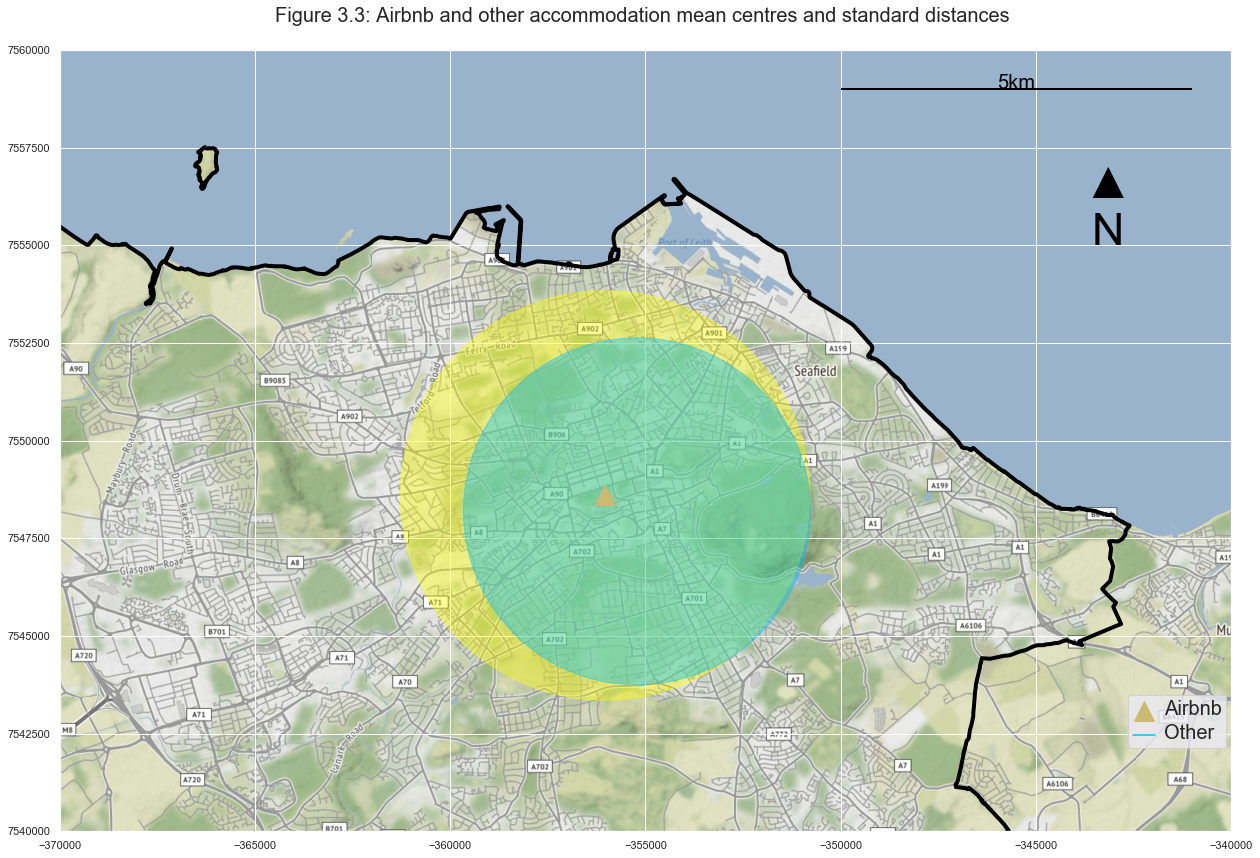

In [153]:
#Plot with means standard distance

f1 = ps.open('gen_data/airbnb.shp') 
f2 = ps.open('gen_data/other.shp') 
                     
# get the points
pp_airbnb = PointPattern(np.asarray([pnt for pnt in f1]))
f1.close() # why we need to call f.close()?

pp_accom = PointPattern(np.asarray([pnt for pnt in f2]))
f2.close() # why we need to call f.close()?
                                        
# mean center calculation
mc1 = mean_center(pp_airbnb.points)

# mean center calculation
mc2 = mean_center(pp_accom.points)

ax2 = edinburgh.plot(color="none", figsize=(21, 15))

ax2.plot(mc1[0], mc1[1], 'y^', label='Airbnb', markersize=20)

ax2.plot(mc2[0], mc2[1], 'r^', label='Other', markersize=20)
ax2.legend(numpoints=1)

stdd = std_distance(pp_airbnb.points)
circle1 = plt.Circle((mc1[0], mc1[1]),stdd, color="yellow", edgecolor="black",
                     alpha=0.4)
ax2.add_artist(circle1)

stdd2 = std_distance(pp_accom.points)
circle2 = plt.Circle((mc2[0], mc2[1]),stdd2, color="deepskyblue", 
                     edgecolor="black", 
                     alpha=0.4)
ax2.add_artist(circle2)


ax2.set_title("Figure 3.3: Airbnb and other accommodation mean centres and \
standard distances \n",
              {'fontsize': 20})

ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.1))
leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('20')

map_format2()
plt.savefig("figures/mean_sd")

## <a id="Airbnb and other accommodation capacity Data Zone level comparison">6. Airbnb and other accommodation capacity Data Zone level comparison <a/>

In [158]:
datazone3["airbnb_den"].max()

71.70189571032434

In [156]:
#Kernal density plot
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
sns.kdeplot(datazone3["airbnb_den"], bw=1, label="Airbnb", color="yellow",
            ax=ax)
sns.kdeplot(datazone3["other_den"], bw=1, label="Other", color="deepskyblue",
            ax=ax)
plt.xlabel("Accommodation capacity per ha")
plt.ylabel("Density")
plt.annotate("Airbnb max",(71.7,0), (71.7,0.05), color="black", 
             arrowprops=dict(arrowstyle="->", color="black"))
plt.annotate("Other max",(101.7,0), (101.7,0.05), color="black", 
             arrowprops=dict(arrowstyle="->", color="black"))
ax.set_title(label='Figure 3.4: Kernal density plot of Airbnb and other acommodation Data Zone distribution \n')
plt.xlim((0,120))
plt.savefig("figures/prob_dens")

plt.close()

In [136]:
#Plot of Airbnb
ax2 = edinburgh.plot(figsize=(21, 15))

ax2 = plot_dataframe(datazone3, column="norm_airbnb_den", ax=ax2, alpha=0.8,  
                     k=5, legend=True, edgecolor="white", linewidth=0.25, 
                     figsize=(15, 30), cmap=plt.cm.viridis, 
                     scheme='user_defined', legend_kwds={'loc': "lower right"}, 
                     classification_kwds={'bins':[5,10,20,40,60]})
leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('20')

ax2.set_title("Figure 3.5: Airbnb accommodation normalised capacity \
by Data Zone \n", {'fontsize': 20})
    
map_format2()
plt.savefig("figures/airbnb")

plt.close()

In [141]:
#Airbnb autocorrelation
lisa1 = ps.Moran_Local(datazone4['norm_airbnb_den'].values, w_queen, 
                       permutations=999)
viz.plot_lisa_cluster(data,lisa1, figsize=(10,10), 
                      savein="figures/airbnb_LISA.png", 
                      title="Figure 3.6 Airbnb accommodation \
                      normalised capacity by Data Zone LISA", leg_loc=4)

plt.close()

In [138]:
#Plot of Other
ax2 = edinburgh.plot(figsize=(21, 15))

ax2 = plot_dataframe(datazone3, column="norm_other_den", ax=ax2, alpha=0.8, k=5, 
                     legend=True, edgecolor="white", linewidth=0.25, 
                     figsize=(15, 30), cmap=plt.cm.viridis, scheme='user_defined',
                     legend_kwds={'loc': "lower right"}, 
                     classification_kwds={'bins':[5,10,20,40,60]})

leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('20')


ax2.set_title("Figure 3.7: Other accommodation \
normalised capacity by Data Zone \n",
              {'fontsize': 20})

map_format2()
plt.savefig("figures/accom")

plt.close()

In [142]:
#Other autocorrelation
lisa2 = ps.Moran_Local(datazone4['norm_other_den'].values, w_queen, 
                       permutations=999)
viz.plot_lisa_cluster(data,lisa2, figsize=(10,10), 
                      savein="figures/other_LISA.png",
                     title="Figure 3.8 Other accommodation LISA plot", 
                      leg_loc=4)

plt.close()

In [143]:
#Difference in relative concentration
ax2 = edinburgh.plot(figsize=(21, 15))

plot_dataframe(datazone3, column='norm_diff_den', ax=ax2, alpha=0.8, k=5, 
               legend=True, edgecolor="white", linewidth=0.25, cmap=plt.cm.PuOr, 
               scheme='user_defined', legend_kwds={'loc': "lower right"}, 
               classification_kwds={'bins':[-30, -10, 10, 30]})

ax2.set_title("Figure 3.9: Normalised capacity difference by Data Zone \n", 
              {'fontsize': 20})

leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('20')
    
map_format2()
plt.savefig("figures/norm_diff")

plt.close()

In [144]:
#Bivariate autocorrelation
w_queen = ps.weights.Queen.from_dataframe(datazone4)
lisa2 = ps.Moran_Local_BV(datazone4['norm_airbnb_den'].values, 
                          datazone4['norm_other_den'].values, w_queen, 
                          permutations=999)

viz.plot_lisa_cluster(data,lisa2, figsize=(10,10), 
                      savein="figures/bivar_LISA.png",
                     title="Figure 3.10 Airbnb and other \
                     accommodation bivariate LISA", 
                      leg_loc=4)

plt.close()

## <a id="Deprivation">6. Deprivation <a/>

In [145]:
#Quintiles of deprivation
ax2 = edinburgh.plot(figsize=(21, 15), color="none")

plot_dataframe(datazone3, column='SIMD_2016_Decile', ax=ax2, alpha=0.8, k=5, 
               legend=True, edgecolor="white", linewidth=0.25, 
               cmap=plt.cm.coolwarm_r, 
               scheme='user_defined', legend_kwds={'loc': "lower right"}, 
               classification_kwds={'bins':[2, 4, 6, 8, 10]})

leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('20')
leg.get_texts()[0].set_text("Quntile 1 (Most deprived)")
leg.get_texts()[1].set_text("Quntile 2")
leg.get_texts()[2].set_text("Quntile 3")
leg.get_texts()[3].set_text("Quntile 4")
leg.get_texts()[4].set_text("Quntile 5 (Least deprived)")
    
ax2.set_title("Figure 3.11: Scotish Index of Multiple Deprivation \
Edinburgh Quintiles\n",
              {'fontsize': 20})
    
    
map_format()

plt.savefig("figures/SIMD")

plt.close()

In [146]:
#Quintile of deprivation share (all dz)

dep_quint_all = pd.DataFrame(datazone3.groupby(by="SIMD_2016_Quintile")\
                             ["OBJECTID"].count())

dep_quint_all.columns = ["all_dz"]

dep_quint_all["share of total"]=  dep_quint_all["all_dz"]/\
dep_quint_all["all_dz"].sum()

dep_quint_all

,all_dz,share of total
SIMD_2016_Quintile,,
1,82,0.137
2,88,0.147
3,85,0.142
4,92,0.154
5,250,0.419


In [147]:
#Quintile of deprivation share (dz with high airbnb density)

datazone5 = datazone3.loc[datazone3["airbnb_denP"] > datazone3["airbnb_denP"]\
                          .quantile(0.90)]

dep_quint_int = pd.DataFrame(datazone5.groupby(by="SIMD_2016_Quintile")\
                             ["OBJECTID"].count())

dep_quint_int.columns = ["high_airb_dens_DZ"]

dep_quint_int["share of total"]=  dep_quint_int["high_airb_dens_DZ"]/\
dep_quint_int["high_airb_dens_DZ"].sum()

dep_quint_int

,high_airb_dens_DZ,share of total
SIMD_2016_Quintile,,
1,1,0.017
2,8,0.133
3,19,0.317
4,14,0.233
5,18,0.300


In [124]:
datazone3["airbnb_denP"].quantile(0.90)

20.883089344696813

In [ ]:
#Plotting wrapper to allow customized chloropleth bins
from distutils.version import LooseVersion
import warnings

import numpy as np
import pandas as pd

def _flatten_multi_geoms(geoms, colors=None):
    """
    Returns Series like geoms and colors, except that any Multi geometries
    are split into their components and colors are repeated for all component
    in the same Multi geometry.  Maintains 1:1 matching of geometry to color.
    Passing `color` is optional, and when no `color` is passed a list of None
    values is returned as `component_colors`.
    "Colors" are treated opaquely and so can actually contain any values.
    Returns
    -------
    components : list of geometry
    component_colors : list of whatever type `colors` contains
    """
    if colors is None:
        colors = [None] * len(geoms)

    components, component_colors = [], []

    if not geoms.geom_type.str.startswith('Multi').any():
        return geoms, colors

    # precondition, so zip can't short-circuit
    assert len(geoms) == len(colors)
    for geom, color in zip(geoms, colors):
        if geom.type.startswith('Multi'):
            for poly in geom:
                components.append(poly)
                # repeat same color for all components
                component_colors.append(color)
        else:
            components.append(geom)
            component_colors.append(color)

    return components, component_colors


def plot_polygon_collection(ax, geoms, values=None, color=None,
                            cmap=None, vmin=None, vmax=None, **kwargs):
    """
    Plots a collection of Polygon and MultiPolygon geometries to `ax`
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        where shapes will be plotted
    geoms : a sequence of `N` Polygons and/or MultiPolygons (can be mixed)
    values : a sequence of `N` values, optional
        Values will be mapped to colors using vmin/vmax/cmap. They should
        have 1:1 correspondence with the geometries (not their components).
        Otherwise follows `color` / `facecolor` kwargs.
    edgecolor : single color or sequence of `N` colors
        Color for the edge of the polygons
    facecolor : single color or sequence of `N` colors
        Color to fill the polygons. Cannot be used together with `values`.
    color : single color or sequence of `N` colors
        Sets both `edgecolor` and `facecolor`
    **kwargs
        Additional keyword arguments passed to the collection
    Returns
    -------
    collection : matplotlib.collections.Collection that was plotted
    """

    try:
        from descartes.patch import PolygonPatch
    except ImportError:
        raise ImportError("The descartes package is required"
                          " for plotting polygons in geopandas.")
    from matplotlib.collections import PatchCollection

    geoms, values = _flatten_multi_geoms(geoms, values)
    if None in values:
        values = None

    # PatchCollection does not accept some kwargs.
    if 'markersize' in kwargs:
        del kwargs['markersize']

    # color=None overwrites specified facecolor/edgecolor with default color
    if color is not None:
        kwargs['color'] = color

    collection = PatchCollection([PolygonPatch(poly) for poly in geoms],
                                 **kwargs)

    if values is not None:
        collection.set_array(np.asarray(values))
        collection.set_cmap(cmap)
        collection.set_clim(vmin, vmax)

    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection


def plot_linestring_collection(ax, geoms, values=None, color=None,
                               cmap=None, vmin=None, vmax=None, **kwargs):
    """
    Plots a collection of LineString and MultiLineString geometries to `ax`
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        where shapes will be plotted
    geoms : a sequence of `N` LineStrings and/or MultiLineStrings (can be
            mixed)
    values : a sequence of `N` values, optional
        Values will be mapped to colors using vmin/vmax/cmap. They should
        have 1:1 correspondence with the geometries (not their components).
    color : single color or sequence of `N` colors
        Cannot be used together with `values`.
    Returns
    -------
    collection : matplotlib.collections.Collection that was plotted
    """
    from matplotlib.collections import LineCollection

    geoms, values = _flatten_multi_geoms(geoms, values)
    if None in values:
        values = None

    # LineCollection does not accept some kwargs.
    if 'markersize' in kwargs:
        del kwargs['markersize']

    # color=None gives black instead of default color cycle
    if color is not None:
        kwargs['color'] = color

    segments = [np.array(linestring)[:, :2] for linestring in geoms]
    collection = LineCollection(segments, **kwargs)

    if values is not None:
        collection.set_array(np.asarray(values))
        collection.set_cmap(cmap)
        collection.set_clim(vmin, vmax)

    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection


def plot_point_collection(ax, geoms, values=None, color=None,
                          cmap=None, vmin=None, vmax=None,
                          marker='o', markersize=None, **kwargs):
    """
    Plots a collection of Point and MultiPoint geometries to `ax`
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        where shapes will be plotted
    geoms : sequence of `N` Points or MultiPoints
    values : a sequence of `N` values, optional
        Values mapped to colors using vmin, vmax, and cmap.
        Cannot be specified together with `color`.
    markersize : scalar or array-like, optional
        Size of the markers. Note that under the hood ``scatter`` is
        used, so the specified value will be proportional to the
        area of the marker (size in points^2).
    Returns
    -------
    collection : matplotlib.collections.Collection that was plotted
    """
    if values is not None and color is not None:
        raise ValueError("Can only specify one of 'values' and 'color' kwargs")

    geoms, values = _flatten_multi_geoms(geoms, values)
    if None in values:
        values = None
    x = [p.x for p in geoms]
    y = [p.y for p in geoms]

    # matplotlib 1.4 does not support c=None, and < 2.0 does not support s=None
    if values is not None:
        kwargs['c'] = values
    if markersize is not None:
        kwargs['s'] = markersize

    collection = ax.scatter(x, y, color=color, vmin=vmin, vmax=vmax, cmap=cmap,
                            marker=marker, **kwargs)
    return collection


def plot_series(s, cmap=None, color=None, ax=None, figsize=None, **style_kwds):
    """
    Plot a GeoSeries.
    Generate a plot of a GeoSeries geometry with matplotlib.
    Parameters
    ----------
    s : Series
        The GeoSeries to be plotted. Currently Polygon,
        MultiPolygon, LineString, MultiLineString and Point
        geometries can be plotted.
    cmap : str (default None)
        The name of a colormap recognized by matplotlib. Any
        colormap will work, but categorical colormaps are
        generally recommended. Examples of useful discrete
        colormaps include:
            tab10, tab20, Accent, Dark2, Paired, Pastel1, Set1, Set2
    color : str (default None)
        If specified, all objects will be colored uniformly.
    ax : matplotlib.pyplot.Artist (default None)
        axes on which to draw the plot
    figsize : pair of floats (default None)
        Size of the resulting matplotlib.figure.Figure. If the argument
        ax is given explicitly, figsize is ignored.
    **style_kwds : dict
        Color options to be passed on to the actual plot function, such
        as ``edgecolor``, ``facecolor``, ``linewidth``, ``markersize``,
        ``alpha``.
    Returns
    -------
    ax : matplotlib axes instance
    """
    if 'colormap' in style_kwds:
        warnings.warn("'colormap' is deprecated, please use 'cmap' instead "
                      "(for consistency with matplotlib)", FutureWarning)
        cmap = style_kwds.pop('colormap')
    if 'axes' in style_kwds:
        warnings.warn("'axes' is deprecated, please use 'ax' instead "
                      "(for consistency with pandas)", FutureWarning)
        ax = style_kwds.pop('axes')

    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')

    if s.empty:
        warnings.warn("The GeoSeries you are attempting to plot is "
                      "empty. Nothing has been displayed.", UserWarning)
        return ax

    # if cmap is specified, create range of colors based on cmap
    values = None
    if cmap is not None:
        values = np.arange(len(s))
        if hasattr(cmap, 'N'):
            values = values % cmap.N
        style_kwds['vmin'] = style_kwds.get('vmin', values.min())
        style_kwds['vmax'] = style_kwds.get('vmax', values.max())

    geom_types = s.geometry.type
    poly_idx = np.asarray((geom_types == 'Polygon')
                          | (geom_types == 'MultiPolygon'))
    line_idx = np.asarray((geom_types == 'LineString')
                          | (geom_types == 'MultiLineString'))
    point_idx = np.asarray((geom_types == 'Point')
                          | (geom_types == 'MultiPoint'))

    # plot all Polygons and all MultiPolygon components in the same collection
    polys = s.geometry[poly_idx]

    if not polys.empty:
        # color overrides both face and edgecolor. As we want people to be
        # able to use edgecolor as well, pass color to facecolor
        facecolor = style_kwds.pop('facecolor', None)
        if color is not None:
            facecolor = color
        values_ = values[poly_idx] if cmap else None
        plot_polygon_collection(ax, polys, values_, facecolor=facecolor,
                                cmap=cmap, **style_kwds)

    # plot all LineStrings and MultiLineString components in same collection
    lines = s.geometry[line_idx]
    if not lines.empty:
        values_ = values[line_idx] if cmap else None
        plot_linestring_collection(ax, lines, values_, color=color, cmap=cmap,
                                   **style_kwds)

    # plot all Points in the same collection
    points = s.geometry[point_idx]
    if not points.empty:
        values_ = values[point_idx] if cmap else None
        plot_point_collection(ax, points, values_, color=color, cmap=cmap,
                              **style_kwds)

    plt.draw()
    return ax


def plot_dataframe(df, column=None, cmap=None, color=None, ax=None, cax=None,
                   categorical=False, legend=False, scheme=None, k=5,
                   vmin=None, vmax=None, markersize=None, figsize=None,
                   legend_kwds=None, classification_kwds=None, **style_kwds):
    """
    Plot a GeoDataFrame.
    Generate a plot of a GeoDataFrame with matplotlib.  If a
    column is specified, the plot coloring will be based on values
    in that column.
    Parameters
    ----------
    df : GeoDataFrame
        The GeoDataFrame to be plotted.  Currently Polygon,
        MultiPolygon, LineString, MultiLineString and Point
        geometries can be plotted.
    column : str, np.array, pd.Series (default None)
        The name of the dataframe column, np.array, or pd.Series to be plotted.
        If np.array or pd.Series are used then it must have same length as
        dataframe. Values are used to color the plot. Ignored if `color` is
        also set.
    cmap : str (default None)
        The name of a colormap recognized by matplotlib.
    color : str (default None)
        If specified, all objects will be colored uniformly.
    ax : matplotlib.pyplot.Artist (default None)
        axes on which to draw the plot
    cax : matplotlib.pyplot Artist (default None)
        axes on which to draw the legend in case of color map.
    categorical : bool (default False)
        If False, cmap will reflect numerical values of the
        column being plotted.  For non-numerical columns, this
        will be set to True.
    legend : bool (default False)
        Plot a legend. Ignored if no `column` is given, or if `color` is given.
    scheme : str (default None)
        Name of a choropleth classification scheme (requires mapclassify).
        A mapclassify.Map_Classifier object will be used
        under the hood. Supported are all schemes provided by mapclassify (e.g.
        'Box_Plot', 'Equal_Interval', 'Fisher_Jenks', 'Fisher_Jenks_Sampled',
        'HeadTail_Breaks', 'Jenks_Caspall', 'Jenks_Caspall_Forced',
        'Jenks_Caspall_Sampled', 'Max_P_Classifier', 'Maximum_Breaks',
        'Natural_Breaks', 'Quantiles', 'Percentiles', 'Std_Mean',
        'User_Defined'). Arguments can be passed in classification_kwds.
    k : int (default 5)
        Number of classes (ignored if scheme is None)
    vmin : None or float (default None)
        Minimum value of cmap. If None, the minimum data value
        in the column to be plotted is used.
    vmax : None or float (default None)
        Maximum value of cmap. If None, the maximum data value
        in the column to be plotted is used.
    markersize : str or float or sequence (default None)
        Only applies to point geometries within a frame.
        If a str, will use the values in the column of the frame specified
        by markersize to set the size of markers. Otherwise can be a value
        to apply to all points, or a sequence of the same length as the
        number of points.
    figsize : tuple of integers (default None)
        Size of the resulting matplotlib.figure.Figure. If the argument
        axes is given explicitly, figsize is ignored.
    legend_kwds : dict (default None)
        Keyword arguments to pass to ax.legend()
    classification_kwds : dict (default None)
        Keyword arguments to pass to mapclassify
    **style_kwds : dict
        Color options to be passed on to the actual plot function, such
        as ``edgecolor``, ``facecolor``, ``linewidth``, ``markersize``,
        ``alpha``.
    Returns
    -------
    ax : matplotlib axes instance
    """
    if 'colormap' in style_kwds:
        warnings.warn("'colormap' is deprecated, please use 'cmap' instead "
                      "(for consistency with matplotlib)", FutureWarning)
        cmap = style_kwds.pop('colormap')
    if 'axes' in style_kwds:
        warnings.warn("'axes' is deprecated, please use 'ax' instead "
                      "(for consistency with pandas)", FutureWarning)
        ax = style_kwds.pop('axes')
    if column is not None and color is not None:
        warnings.warn("Only specify one of 'column' or 'color'. Using "
                      "'color'.", UserWarning)
        column = None

    import matplotlib
    import matplotlib.pyplot as plt

    if ax is None:
        if cax is not None:
            raise ValueError("'ax' can not be None if 'cax' is not.")
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')

    if df.empty:
        warnings.warn("The GeoDataFrame you are attempting to plot is "
                      "empty. Nothing has been displayed.", UserWarning)
        return ax

    if isinstance(markersize, str):
        markersize = df[markersize].values

    if column is None:
        return plot_series(df.geometry, cmap=cmap, color=color, ax=ax,
                           figsize=figsize, markersize=markersize,
                           **style_kwds)

    # To accept pd.Series and np.arrays as column
    if isinstance(column, (np.ndarray, pd.Series)):
        if column.shape[0] != df.shape[0]:
            raise ValueError("The dataframe and given column have different "
                             "number of rows.")
        else:
            values = np.asarray(column)
    else:
        values = np.asarray(df[column])

    if values.dtype is np.dtype('O'):
        categorical = True

    # Define `values` as a Series
    if categorical:
        if cmap is None:
            if LooseVersion(matplotlib.__version__) >= '2.0.1':
                cmap = 'tab10'
            elif LooseVersion(matplotlib.__version__) >= '2.0.0':
                # Erroneous name.
                cmap = 'Vega10'
            else:
                cmap = 'Set1'
        categories = list(set(values))
        categories.sort()
        valuemap = dict((k, v) for (v, k) in enumerate(categories))
        values = np.array([valuemap[k] for k in values])

    if scheme is not None:
        if classification_kwds is None:
            classification_kwds = {}
        if 'k' not in classification_kwds:
                classification_kwds['k'] = k

        binning = _mapclassify_choro(values, scheme, **classification_kwds)
        # set categorical to True for creating the legend
        categorical = True
        binedges = [values.min()] + binning.bins.tolist()
        categories = ['{0:.2f} - {1:.2f}'.format(binedges[i], binedges[i+1])
                      for i in range(len(binedges)-1)]
        values = np.array(binning.yb)

    mn = values[~np.isnan(values)].min() if vmin is None else vmin
    mx = values[~np.isnan(values)].max() if vmax is None else vmax

    geom_types = df.geometry.type
    poly_idx = np.asarray((geom_types == 'Polygon')
                          | (geom_types == 'MultiPolygon'))
    line_idx = np.asarray((geom_types == 'LineString')
                          | (geom_types == 'MultiLineString'))
    point_idx = np.asarray((geom_types == 'Point')
                          | (geom_types == 'MultiPoint'))

    # plot all Polygons and all MultiPolygon components in the same collection
    polys = df.geometry[poly_idx]
    if not polys.empty:
        plot_polygon_collection(ax, polys, values[poly_idx],
                                vmin=mn, vmax=mx, cmap=cmap, **style_kwds)

    # plot all LineStrings and MultiLineString components in same collection
    lines = df.geometry[line_idx]
    if not lines.empty:
        plot_linestring_collection(ax, lines, values[line_idx],
                                   vmin=mn, vmax=mx, cmap=cmap, **style_kwds)

    if cax is not None:
        cbar_kwargs = {"cax": cax}
    else:
        cbar_kwargs = {"ax": ax}

    # plot all Points in the same collection
    points = df.geometry[point_idx]
    if not points.empty:
        if isinstance(markersize, np.ndarray):
            markersize = markersize[point_idx]
        plot_point_collection(ax, points, values[point_idx], vmin=mn, vmax=mx,
                              markersize=markersize, cmap=cmap,
                              **style_kwds)

    if legend and not color:
        from matplotlib.lines import Line2D
        from matplotlib.colors import Normalize
        from matplotlib import cm

        norm = Normalize(vmin=mn, vmax=mx)
        n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
        if categorical:
            patches = []
            for value, cat in enumerate(categories):
                patches.append(
                    Line2D([0], [0], linestyle="none", marker="o",
                           alpha=style_kwds.get('alpha', 1), markersize=10,
                           markerfacecolor=n_cmap.to_rgba(value),
                           markeredgewidth=0))
            if legend_kwds is None:
                legend_kwds = {}
            legend_kwds.setdefault('numpoints', 1)
            legend_kwds.setdefault('loc', 'best')
            ax.legend(patches, categories, **legend_kwds)
        else:
            n_cmap.set_array([])
            ax.get_figure().colorbar(n_cmap, **cbar_kwargs)

    plt.draw()
    return ax


def _mapclassify_choro(values, scheme, **classification_kwds):
    """
    Wrapper for choropleth schemes from mapclassify for use with plot_dataframe
    Parameters
    ----------
    values
        Series to be plotted
    scheme : str
        One of mapclassify classification schemes
        Options are Box_Plot, Equal_Interval, Fisher_Jenks,
        Fisher_Jenks_Sampled, HeadTail_Breaks, Jenks_Caspall,
        Jenks_Caspall_Forced, Jenks_Caspall_Sampled, Max_P_Classifier,
        Maximum_Breaks, Natural_Breaks, Quantiles, Percentiles, Std_Mean,
        User_Defined
    **classification_kwds : dict
        Keyword arguments for classification scheme
        For details see mapclassify documentation:
        https://mapclassify.readthedocs.io/en/latest/api.html
    Returns
    -------
    binning
        Binning objects that holds the Series with values replaced with
        class identifier and the bins.
    """
    try:
        import mapclassify.classifiers
    except ImportError:
        raise ImportError(
            "The 'mapclassify' package is required to use the 'scheme' "
            "keyword")

    schemes = {}
    for classifier in mapclassify.classifiers.CLASSIFIERS:
        schemes[classifier.lower()] = getattr(mapclassify.classifiers,
                                              classifier)

    scheme = scheme.lower()
    if scheme not in schemes:
        raise ValueError("Invalid scheme. Scheme must be in the"
                         " set: %r" % schemes.keys())
    if classification_kwds['k'] is not None:
        try:
            from inspect import getfullargspec as getspec
        except ImportError:
            from inspect import getargspec as getspec
        spec = getspec(schemes[scheme].__init__)
        if 'k' not in spec.args:
            del classification_kwds['k']
    try:
        binning = schemes[scheme](values, **classification_kwds)
    except TypeError:
        raise TypeError("Invalid keyword argument for %r " % scheme)
    return binning
